## Скачиваем данные

```
mkdir ./data
wget https://s3-us-west-2.amazonaws.com/lenta-news-dataset/news_lenta.csv -O ./data/lenta_data.csv
```

In [ ]:
import nltk
nltk.download('stopwords')


------------

## Пример использования токенайзера

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
from tqdm import tqdm_notebook as tqdm
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn import metrics
from collections import Counter
from nltk.corpus import stopwords
from spacy.symbols import PRON
from ru2 import Russian2
from sklearn.model_selection import train_test_split
stopwords = stopwords.words('russian')

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from linguistics import Linguistic

STOPLIST = set(stopwords)
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","«","»"]

In [2]:
def plot_top(common_word,common_counts,name):
    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=common_word, y=common_counts)
    plt.title('Наиболее распространенные слова, используемые в текстах по теме %s' % name)
    plt.show();

In [3]:
all_data = pd.read_csv('./data/lenta_data.csv')
all_data.head()

,tags,text,title,topic,url
0,Общество,Миллиардер Илон Маск в резкой форме ответил бр...,Илон Маск назвал педофилом спасавшего детей из...,Мир,https://lenta.ru/news/2018/07/16/su57/
1,Рынки,США и их западные союзники рассматривают возмо...,США задумались о распечатывании нефтяного резерва,Экономика,https://lenta.ru/news/2018/07/16/foes/
2,Преступность,Празднование победы сборной Франции на чемпион...,Празднование победы на ЧМ во Франции закончило...,Мир,https://lenta.ru/news/2018/07/15/fra_bezumie/
3,Политика,География использования лимузинов проекта «Кор...,Песков рассказал о планах на президентские лим...,Россия,https://lenta.ru/news/2018/07/16/delo_shyut/
4,Музыка,Американская поп-певица Бритни Спирс случайно ...,Грудь Бритни Спирс вновь выскочила из лифчика ...,Культура,https://lenta.ru/news/2018/07/16/pedomusk/


нас будет интересовать только текст новости и топик к которому данный текст отностится.

In [4]:
all_data = all_data[['title','topic']]
all_data.tail()


,title,topic
699741,Леворадикалы создают предвыборный блок,Россия
699742,Литва засудила участников переворота 91 года,Мир
699743,Коржаков готов рассказать Генпрокуратуре про ф...,Россия
699744,Еще одно землетрясение в Турции: один человек ...,Мир
699745,Киргизия ведет бои на границах с Таджикистаном...,Мир


Посмотрим на количество текстов по каждому из представленных топиков.

In [5]:
all_data.groupby('topic',group_keys=False)['title'].count().sort_values(ascending=False)

topic
Россия               158072
Мир                  134334
Экономика             77673
Спорт                 62463
Культура              52600
Бывший СССР           52018
Наука и техника       51869
Интернет и СМИ        43313
Из жизни              26356
Силовые структуры     18480
Бизнес                 7398
Ценности               6832
Путешествия            6045
69-я параллель         1095
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Дом                       6
Оружие                    3
ЧМ-2014                   2
Сочи                      1
МедНовости                1
Name: title, dtype: int64

## Классификация по двум классам

выбираем два самых популярных топика для классификации: Россия и Мир

In [6]:
def get_data_by_topics(data,topics,test_size=.33):
    df=data[data['topic'].isin(topics)]
    train, test = train_test_split(df, test_size=test_size, random_state=42)
    print('Для топиков: ',topics)
    print('Размерность данных для тренировки:', train.shape)
    print('Размерность данных для тестирования:', test.shape)
    return df, train, test

df,train,test = get_data_by_topics(all_data, ['Россия','Мир'])

Для топиков:  ['Россия', 'Мир']
Размерность данных для тренировки: (195912, 2)
Размерность данных для тестирования: (96494, 2)


In [7]:
ru_nlp = Russian2()
ru_nlp.add_pipe(ru_nlp.create_pipe('sentencizer'))
ling=Linguistic(ru_nlp, STOPLIST, punctuations=SYMBOLS)

In [8]:
ru_text = [text for text in train[train['topic'] == 'Россия']['title']]
world_text = [text for text in train[train['topic'] == 'Мир']['title']]


In [9]:
ru_clean = pd.Series(ling.cleanup(ru_text,show_progress=tqdm))
ru_clean = ' '.join(ru_clean).split()

world_clean = pd.Series(ling.cleanup(world_text,show_progress=tqdm))
world_clean = ' '.join(world_clean).split()

In [10]:
ru_counts = Counter(ru_clean)
world_counts = Counter(world_clean)

ru_common_words = [word[0] for word in ru_counts.most_common(20)]
ru_common_counts = [word[1] for word in ru_counts.most_common(20)]

world_common_words = [word[0] for word in world_counts.most_common(20)]
world_common_counts = [word[1] for word in world_counts.most_common(20)]

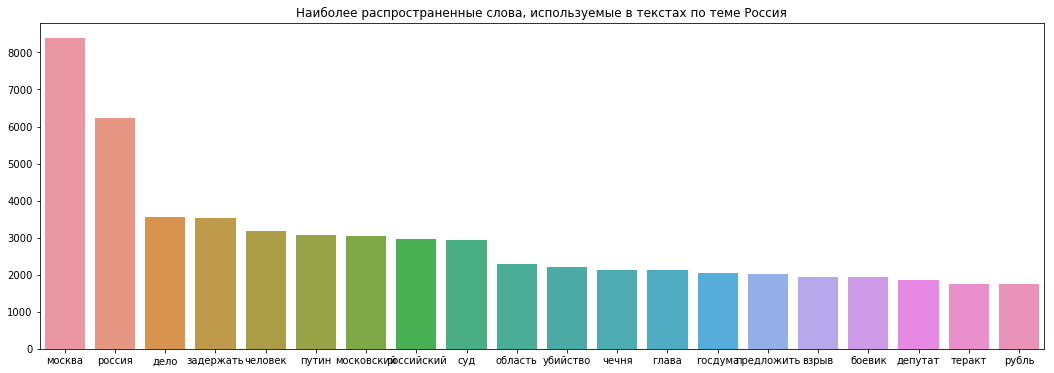

In [11]:
plot_top(ru_common_words,ru_common_counts, 'Россия')

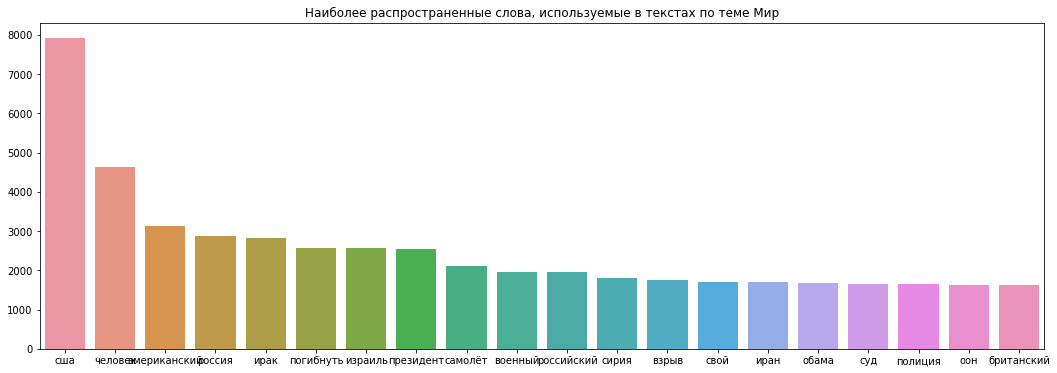

In [12]:
plot_top(world_common_words, world_common_counts, 'Мир')

In [13]:
class CleanTextTransformer(TransformerMixin):
    
    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r"," ")
    text = text.lower()
    return text

def tokenizeText(text):
    tokens = ru_nlp(text)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != PRON else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

def printNMostInformative(vectorizer, clf, N):
    print("Топ %d информативных слов для прогноза." % N)
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Для первого скласса: ")
    for feat in topClass1:
        print(feat)
    print("Для второго скласса: ")
    for feat in topClass2:
        print(feat)

In [14]:
vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))
clf = LinearSVC()

pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])

In [15]:
# data
train1 = train['title'].tolist()
labelsTrain1 = train['topic'].tolist()
test1 = test['title'].tolist()
labelsTest1 = test['topic'].tolist()

In [16]:
%%time
pipe.fit(train1, labelsTrain1)


Wall time: 26min 9s


Pipeline(memory=None,
     steps=[('cleanText', <__main__.CleanTextTransformer object at 0x0000000037A525C0>), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [17]:
%%time

# test
preds = pipe.predict(test1)
print("accuracy:", metrics.accuracy_score(labelsTest1, preds))
printNMostInformative(vectorizer, clf, 10)


accuracy: 0.902066449727
Топ 10 информативных слов для прогноза.
Для первого скласса: 
(-2.1111257568144017, 'полминуты')
(-2.0756492559292652, 'неправовой')
(-2.0000046132548857, 'героиновые')
(-1.9717285415228536, 'поручительница')
(-1.9620189925368132, 'плетень')
(-1.9302131732211385, 'каида')
(-1.9260692087535722, 'контролируемой')
(-1.913351621989646, 'бавария')
(-1.8943467223263701, 'дина')
(-1.844882080334707, 'бремен')
Для второго скласса: 
(2.7636552414292233, 'совфеде')
(2.6417040742853906, 'отступиться')
(2.3162706613012674, 'расклад')
(2.2945276370881653, 'клинц')
(2.2753603784059764, 'нарышкин')
(2.244430575938591, 'пушок')
(2.1523598052357289, 'косачев')
(2.1137878345280732, 'онищенко')
(2.0524263556233424, 'авиа')
(1.9718566864868072, 'смотровой')
Wall time: 12min 37s


In [18]:
print(metrics.classification_report(labelsTest1, preds, target_names=df['topic'].unique()))

             precision    recall  f1-score   support

        Мир       0.89      0.90      0.89     44349
     Россия       0.91      0.90      0.91     52145

avg / total       0.90      0.90      0.90     96494



## Многоклассовая классификация

In [19]:
df,train,test = get_data_by_topics(all_data, ['Экономика','Спорт','Культура','Из жизни'])

Для топиков:  ['Экономика', 'Спорт', 'Культура', 'Из жизни']
Размерность данных для тренировки: (146791, 2)
Размерность данных для тестирования: (72301, 2)


In [20]:
vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))
clf = LinearSVC()

pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])

# data
train1 = train['title'].tolist()
labelsTrain1 = train['topic'].tolist()
test1 = test['title'].tolist()
labelsTest1 = test['topic'].tolist()

In [21]:
%%time
pipe.fit(train1, labelsTrain1)


Wall time: 17min 59s


Pipeline(memory=None,
     steps=[('cleanText', <__main__.CleanTextTransformer object at 0x0000000037DB3198>), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [22]:
%%time

# test
preds = pipe.predict(test1)
print("accuracy:", metrics.accuracy_score(labelsTest1, preds))

accuracy: 0.94215847637
Wall time: 8min 45s


In [23]:
print(metrics.classification_report(labelsTest1, preds, target_names=df['topic'].unique()))

             precision    recall  f1-score   support

  Экономика       0.83      0.80      0.82      8661
   Культура       0.93      0.93      0.93     17397
      Спорт       0.97      0.98      0.98     20624
   Из жизни       0.96      0.97      0.97     25619

avg / total       0.94      0.94      0.94     72301

